**Adaptive Drift Detector**
---

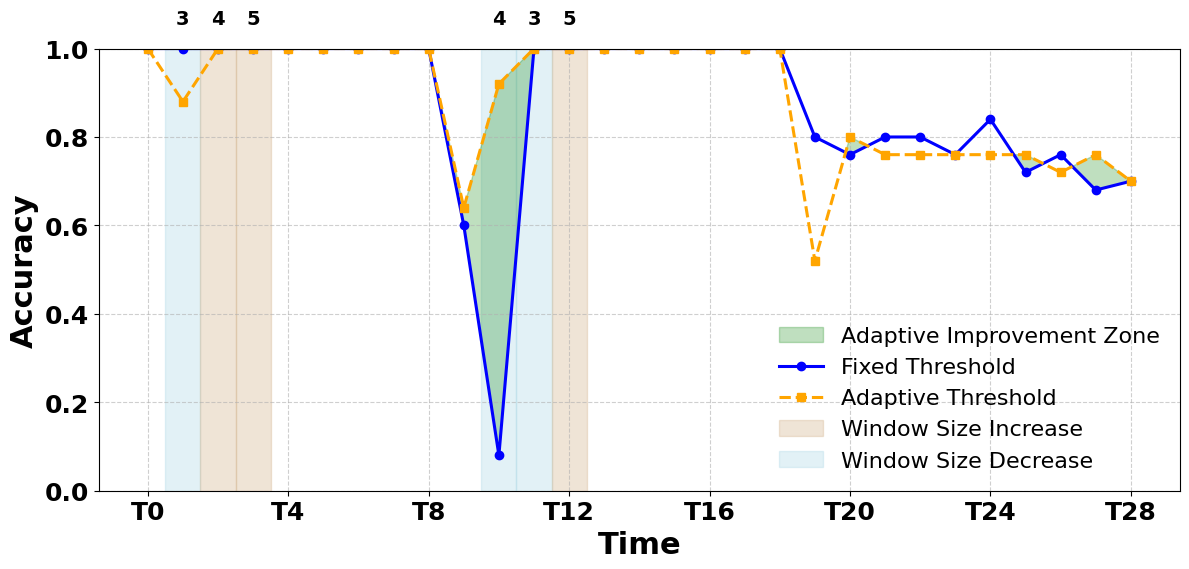

Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: UNDER-sensitive → Reducing window 5→4
Adaptation: UNDER-sensitive → Reducing window 4→3
Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: OVER-sensitive → Increasing window 4→5
Adaptation: UNDER-sensitive → Reducing window 5→4
Adaptation: UNDER-sensitive → Reducing window 4→3
Adaptation: UNDER-sensitive → Reducing window 3→2
Adaptation: OVER-sensitive → Increasing window 2→3
Adaptation: OVER-sensitive → Increasing window 3→4
Adaptation: OVER-sensitive → Increasing window 4→5
ADAPTIVE DRIFT DETECTION RESULTS

DETAILED WINDOW ANALYSIS (showing first 720 results):
----------------------------------------------------------------------------------------------------
Window Blocks       Size Type         Real/Pseudo  Ratio    Accuracy  
----------------------------------------------------------------------------------------------------
1      0-3          4    PSEUDO_DRIFT 0/4          0.00     0.7120000123977661
2   

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary

    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results_1.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct", "window_size"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels ===
summary["time_label"] = ["T" + str(i) for i in range(len(summary))]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Adaptive Improvement Zone ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
ax = plt.gca()
for change in window_changes:
    idx, prev_w, curr_w = change
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
    else:
        color = "#add8e6"  # light blue

    # Draw shaded region
    ax.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

# === Now add text exactly touching the top border ===
ylim = ax.get_ylim()
top_y = ylim[1]

for change in window_changes:
    idx, prev_w, curr_w = change
    plt.text(
        idx, top_y, f"{int(curr_w)}",
        ha="center",
        va="bottom",
        fontsize=14,
        fontweight="bold",
        color="black",
        clip_on=False,
        transform=ax.get_xaxis_transform()  # align to top border of axes
    )

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Accuracy", fontsize=22, fontweight="bold")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(
    ticks=range(0, len(summary), 4),
    labels=[summary["time_label"][i] for i in range(0, len(summary), 4)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = ax.get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")
plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="lower right")

plt.tight_layout()

# === Save and show ===
output_path = "adaptive_vs_fixed_accuracy_with_window_touching.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()

def main():
    des_df = pd.read_csv('/content/df_des_gradual.csv')
    acc_df = pd.read_csv('/content/Ground.csv')
    scaler = MinMaxScaler()
    des_df['DES_scaled'] = scaler.fit_transform(des_df[['DES']])
    des_values = des_df['DES_scaled'].tolist()
    detector = AdaptiveDriftDetector(
        threshold=0.2,
        initial_window_size=4,
        trend_length=10,
        adaptation_step=1,
        min_window=2,
        max_window=5
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()

In [3]:
import pandas as pd
adapative_df=pd.read_csv('/content/adaptive_drift_results.csv')
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,adaptive_prediction,ground_truth,Fixed threhold prediction,TP,FP,TN,FN,block_group,TP1,FP1,TN1,FN1
0,1,0-4,5,PSEUDO_DRIFT,0/5,0.0,0.608,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
1,2,5-9,5,PSEUDO_DRIFT,0/5,0.0,0.680,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
2,3,10-14,5,PSEUDO_DRIFT,0/5,0.0,0.592,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
3,4,15-19,5,PSEUDO_DRIFT,0/5,0.0,0.620,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
4,5,20-24,5,PSEUDO_DRIFT,0/5,0.0,0.632,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,3477-3481,5,PSEUDO_DRIFT,2/3,0.4,0.280,PSEUDO_DRIFT,REAL_DRIFT,REAL_DRIFT,0,0,0,1,705,1,0,0,0
716,717,3482-3486,5,REAL_DRIFT,5/0,1.0,0.288,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT,1,0,0,0,705,1,0,0,0
717,718,3487-3491,5,PSEUDO_DRIFT,1/4,0.2,0.648,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,705,0,0,1,0
718,719,3492-3496,5,PSEUDO_DRIFT,1/4,0.2,0.352,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,0,0,0,1


In [4]:
import pandas as pd
df_summary=pd.read_csv('/content/MPDD.csv')
df_summary

,Unnamed: 0,block_range,total_blocks,avg_DES,final_drift
0,0,0-4,5,0.097066,PSEUDO_DRIFT
1,1,5-9,5,0.149878,PSEUDO_DRIFT
2,2,10-14,5,0.098997,PSEUDO_DRIFT
3,3,15-19,5,0.109881,PSEUDO_DRIFT
4,4,20-24,5,0.159724,PSEUDO_DRIFT
...,...,...,...,...,...
715,715,3575-3579,5,3.559436,PSEUDO_DRIFT
716,716,3580-3584,5,3.625890,PSEUDO_DRIFT
717,717,3585-3589,5,0.117498,PSEUDO_DRIFT
718,718,3590-3594,5,2.749078,PSEUDO_DRIFT


In [5]:
import pandas as pd

# Assume your DataFrame is called df
# Example: df = pd.read_csv("your_file.csv")

# --- Adaptive Prediction based on drift_ratio ---
adapative_df["adaptive_prediction"] = adapative_df["drift_ratio"].apply(lambda x: "REAL_DRIFT" if x > 0.5 else "PSEUDO_DRIFT")

# --- Ground Truth based on accuracy ---
adapative_df["ground_truth"] = adapative_df["accuracy"].apply(lambda x: "PSEUDO_DRIFT" if x > 0.5 else "REAL_DRIFT")

adapative_df["Fixed threhold prediction"]= df_summary["final_drift"]
# --- Display the result ---
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,adaptive_prediction,ground_truth,Fixed threhold prediction,TP,FP,TN,FN,block_group,TP1,FP1,TN1,FN1
0,1,0-4,5,PSEUDO_DRIFT,0/5,0.0,0.608,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
1,2,5-9,5,PSEUDO_DRIFT,0/5,0.0,0.680,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
2,3,10-14,5,PSEUDO_DRIFT,0/5,0.0,0.592,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
3,4,15-19,5,PSEUDO_DRIFT,0/5,0.0,0.620,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
4,5,20-24,5,PSEUDO_DRIFT,0/5,0.0,0.632,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,3477-3481,5,PSEUDO_DRIFT,2/3,0.4,0.280,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,1,0,0,0
716,717,3482-3486,5,REAL_DRIFT,5/0,1.0,0.288,REAL_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,1,0,0,0,705,1,0,0,0
717,718,3487-3491,5,PSEUDO_DRIFT,1/4,0.2,0.648,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,705,0,0,1,0
718,719,3492-3496,5,PSEUDO_DRIFT,1/4,0.2,0.352,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,0,0,0,1


In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.7486111111111111
F1 Score: 0.6680498010514165
Precision: 0.8139866698595147
Recall: 0.7486111111111111
Confusion Matrix:
 [[515   0]
 [181  24]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.74      1.00      0.85       515
  REAL_DRIFT       1.00      0.12      0.21       205

    accuracy                           0.75       720
   macro avg       0.87      0.56      0.53       720
weighted avg       0.81      0.75      0.67       720



In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["adaptive_prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.8888888888888888
F1 Score: 0.884243183499689
Precision: 0.8892326894546652
Recall: 0.8888888888888888
Confusion Matrix:
 [[498  17]
 [ 63 142]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.89      0.97      0.93       515
  REAL_DRIFT       0.89      0.69      0.78       205

    accuracy                           0.89       720
   macro avg       0.89      0.83      0.85       720
weighted avg       0.89      0.89      0.88       720



In [8]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,adaptive_prediction,ground_truth,Fixed threhold prediction,TP,FP,TN,FN,block_group,TP1,FP1,TN1,FN1
0,1,0-4,5,PSEUDO_DRIFT,0/5,0.0,0.608,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
1,2,5-9,5,PSEUDO_DRIFT,0/5,0.0,0.680,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
2,3,10-14,5,PSEUDO_DRIFT,0/5,0.0,0.592,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
3,4,15-19,5,PSEUDO_DRIFT,0/5,0.0,0.620,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
4,5,20-24,5,PSEUDO_DRIFT,0/5,0.0,0.632,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,3477-3481,5,PSEUDO_DRIFT,2/3,0.4,0.280,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,1,0,0,0
716,717,3482-3486,5,REAL_DRIFT,5/0,1.0,0.288,REAL_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,1,0,0,0,705,1,0,0,0
717,718,3487-3491,5,PSEUDO_DRIFT,1/4,0.2,0.648,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,705,0,0,1,0
718,719,3492-3496,5,PSEUDO_DRIFT,1/4,0.2,0.352,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,0,0,0,1


In [9]:
adapative_df['window_size'].value_counts()

,count
window_size,
5,651
4,40
3,29


In [10]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP1"] = ((adapative_df["Fixed threhold prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN1"] = ((adapative_df["Fixed threhold prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 15  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary1 = (
    adapative_df.groupby("block_group")[["TP1", "FP1", "TN1", "FN1"]]
    .sum()
    .reset_index()
)

summary1.to_csv("FIXED_block_scores.csv", index=False)

In [11]:
import pandas as pd

# --- Assume adaptive_df already exists with these columns:
# adaptive_df["adaptive_prediction"], adaptive_df["fixed_prediction"], adaptive_df["ground_truth"]

# Define confusion components for ADAPTIVE predictions
adapative_df["TP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

adapative_df["FP"] = ((adapative_df["adaptive_prediction"] == "REAL_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["TN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "PSEUDO_DRIFT")).astype(int)

adapative_df["FN"] = ((adapative_df["adaptive_prediction"] == "PSEUDO_DRIFT") &
                     (adapative_df["ground_truth"] == "REAL_DRIFT")).astype(int)

# --- Group into blocks of 15 (change to 20 if preferred)
block_size = 15  # or 20
adapative_df["block_group"] = (adapative_df.index // block_size) * block_size

# --- Summarize false negatives (and other confusion components if needed)
summary = (
    adapative_df.groupby("block_group")[["TP", "FP", "TN", "FN"]]
    .sum()
    .reset_index()
)

summary
summary.to_csv("adaptive_block_scores.csv", index=False)

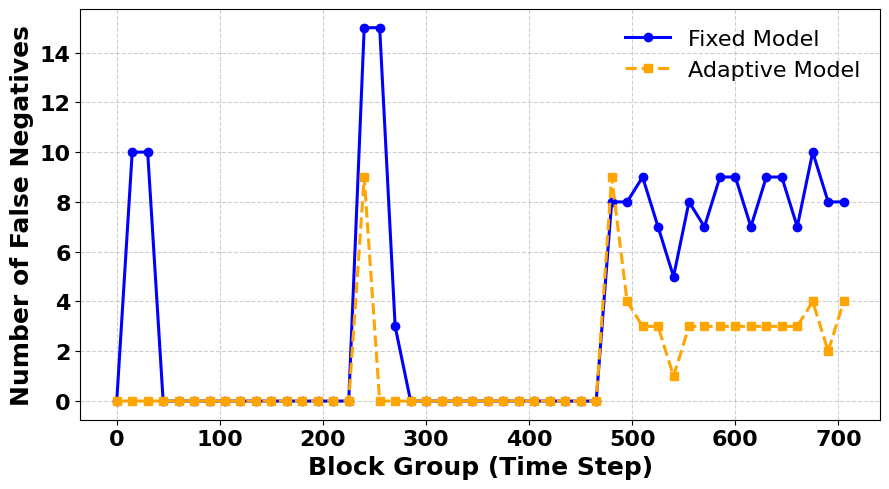

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the two CSV files
adaptive_df = pd.read_csv("adaptive_block_scores.csv")
fixed_df = pd.read_csv("FIXED_block_scores.csv")

# --- ACM Publication-Style Plot ---
plt.figure(figsize=(9, 5))

# Plot Fixed Model (solid)
plt.plot(
    fixed_df["block_group"], fixed_df["FN1"],
    marker='o', color='blue', linewidth=2.2, label='Fixed Model'
)

# Plot Adaptive Model (dotted)
plt.plot(
    adaptive_df["block_group"], adaptive_df["FN"],
    marker='s', color='orange', linewidth=2.2,
    linestyle='--', label='Adaptive Model'
)

# --- Title and Labels ---
#plt.title("False Negatives Across Time Blocks", fontsize=18, fontweight='bold')
plt.xlabel("Block Group (Time Step)", fontsize=18, fontweight='bold')
plt.ylabel("Number of False Negatives", fontsize=18, fontweight='bold')

# --- Ticks and Grid ---
plt.xticks(fontsize=16, fontweight='bold')
plt.yticks(fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# --- Legend ---
plt.legend(fontsize=16, frameon=False)

# --- Layout ---
plt.tight_layout()
plt.show()


In [13]:
adapative_df.to_csv("adaptive_drift_results.csv", index=False)

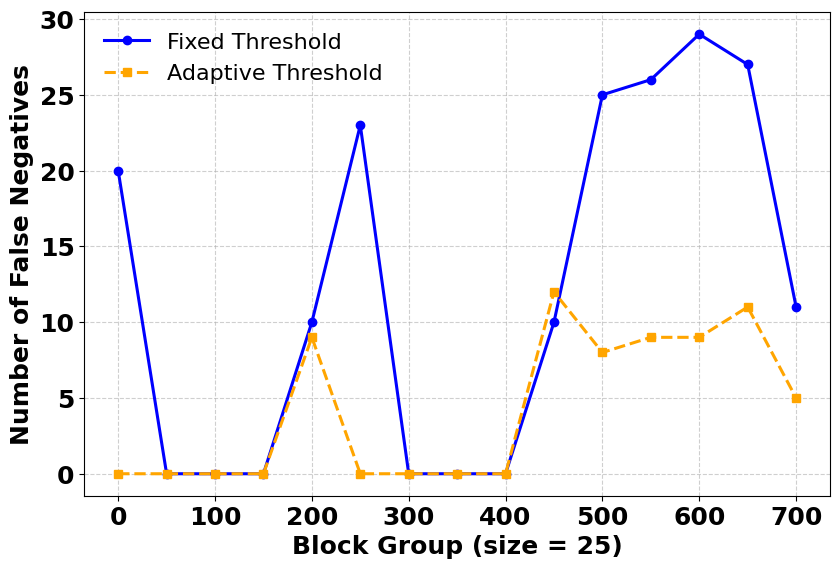

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load your dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and block grouping (every 25 samples) ===
BLOCK_SIZE = 50
df["block_group"] = (df.index // BLOCK_SIZE) * BLOCK_SIZE

# === Aggregate False Negatives per block ===
# FN → Adaptive, FN1 → Fixed
summary = (
    df.groupby("block_group")[["FN", "FN1"]]
    .sum()  # sum of false negatives per block
    .rename(columns={
        "FN": "false_neg_adaptive",
        "FN1": "false_neg_fixed"
    })
    .reset_index()
)

# === Save CSV (optional) ===
out_path = "false_negatives_by_block_25.csv"
summary.to_csv(out_path, index=False)

# === ACM Publication-Style Plot ===
plt.figure(figsize=(8.5, 5.8))

# Fixed Model (solid line)
plt.plot(summary["block_group"], summary["false_neg_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# Adaptive Model (dotted line)
plt.plot(summary["block_group"], summary["false_neg_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Axes & Labels ===
plt.xlabel("Block Group (size = 25)", fontsize=18, fontweight="bold")
plt.ylabel("Number of False Negatives", fontsize=18, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.show()


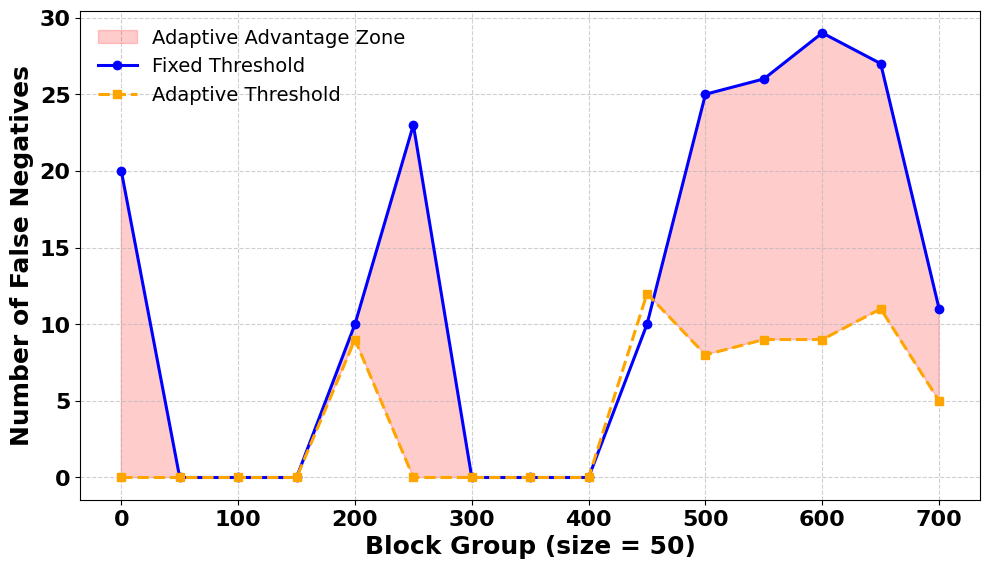

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 50
df["block_group"] = (df.index // BLOCK_SIZE) * BLOCK_SIZE

# === Aggregate False Negatives per block ===
summary = (
    df.groupby("block_group")[["FN", "FN1"]]
    .sum()
    .rename(columns={"FN": "false_neg_adaptive", "FN1": "false_neg_fixed"})
    .reset_index()
)

# === Plot (ACM-style) ===
plt.figure(figsize=(10, 5.8))

# --- Fill the gap between the lines (red zone where Adaptive < Fixed) ---
plt.fill_between(
    summary["block_group"],
    summary["false_neg_adaptive"],
    summary["false_neg_fixed"],
    where=(summary["false_neg_adaptive"] < summary["false_neg_fixed"]),
    color="red",
    alpha=0.2,
    interpolate=True,
    label="Adaptive Advantage Zone"
)

# --- Fixed Threshold (solid blue) ---
plt.plot(summary["block_group"], summary["false_neg_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold (dashed orange) ---
plt.plot(summary["block_group"], summary["false_neg_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Axes & Labels ===
plt.xlabel("Block Group (size = 50)", fontsize=18, fontweight="bold")
plt.ylabel("Number of False Negatives", fontsize=18, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=16, fontweight="bold")
plt.yticks(fontsize=16, fontweight="bold")

# === Legend & Layout ===
plt.legend(fontsize=14, frameon=False, loc="upper left")
plt.tight_layout()
plt.show()


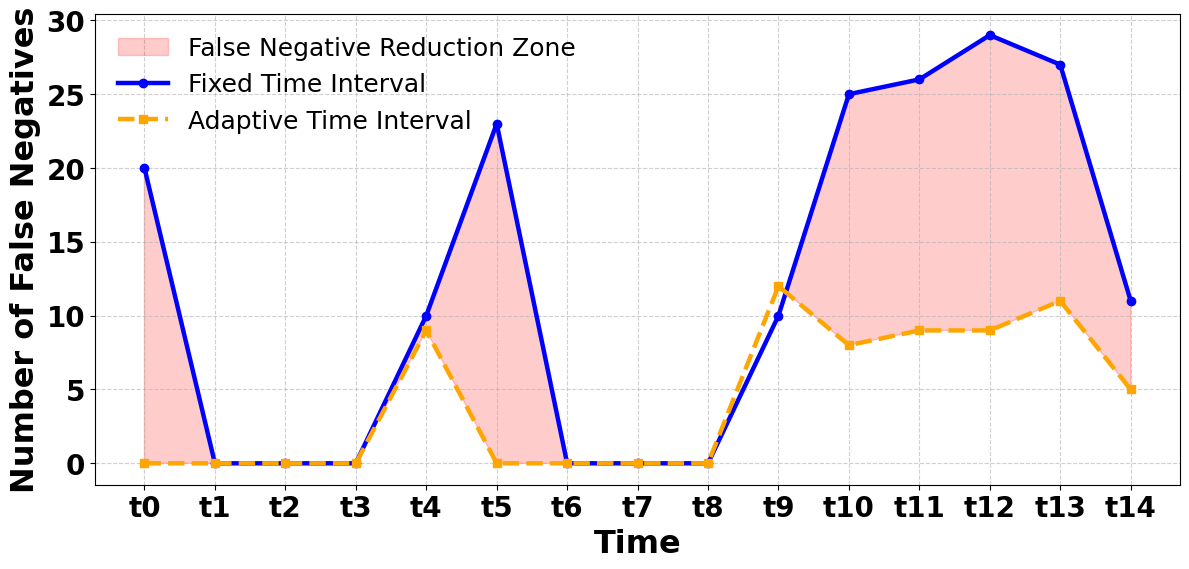

Plot saved successfully as: false_negative_comparison_f4.pdf


In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 50
df["block_group"] = (df.index // BLOCK_SIZE)

# === Aggregate False Negatives per time step ===
summary = (
    df.groupby("block_group")[["FN", "FN1"]]
    .sum()
    .rename(columns={"FN": "false_neg_adaptive", "FN1": "false_neg_fixed"})
    .reset_index()
)

# === Create custom time labels (T0, T1, T2, ...) ===
summary["time_label"] = ["t" + str(i) for i in range(len(summary))]

# === Plot (ACM-style) ===
plt.figure(figsize=(12, 5.8))

# --- Fill red area where Adaptive < Fixed ---
plt.fill_between(
    summary["time_label"],
    summary["false_neg_adaptive"],
    summary["false_neg_fixed"],
    where=(summary["false_neg_adaptive"] < summary["false_neg_fixed"]),
    color="red",
    alpha=0.2,
    interpolate=True,
    label="False Negative Reduction Zone"
)

# --- Fixed Threshold (solid blue) ---
plt.plot(summary["time_label"], summary["false_neg_fixed"],
         marker="o", linestyle="-", linewidth=3.2, color="blue",
         label="Fixed Time Interval")

# --- Adaptive Threshold (dashed orange) ---
plt.plot(summary["time_label"], summary["false_neg_adaptive"],
         marker="s", linestyle="--", linewidth=3.2, color="orange",
         label="Adaptive Time Interval")

# === Axes & Labels ===
plt.xlabel("Time", fontsize=23, fontweight="bold")
plt.ylabel("Number of False Negatives", fontsize=23, fontweight="bold")

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold")

# === Legend & Layout ===
plt.legend(fontsize=18, frameon=False, loc="upper left")
plt.tight_layout()

# === Save as PDF ===
output_path = "false_negative_comparison_f4.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")

plt.show()

print(f"Plot saved successfully as: {output_path}")


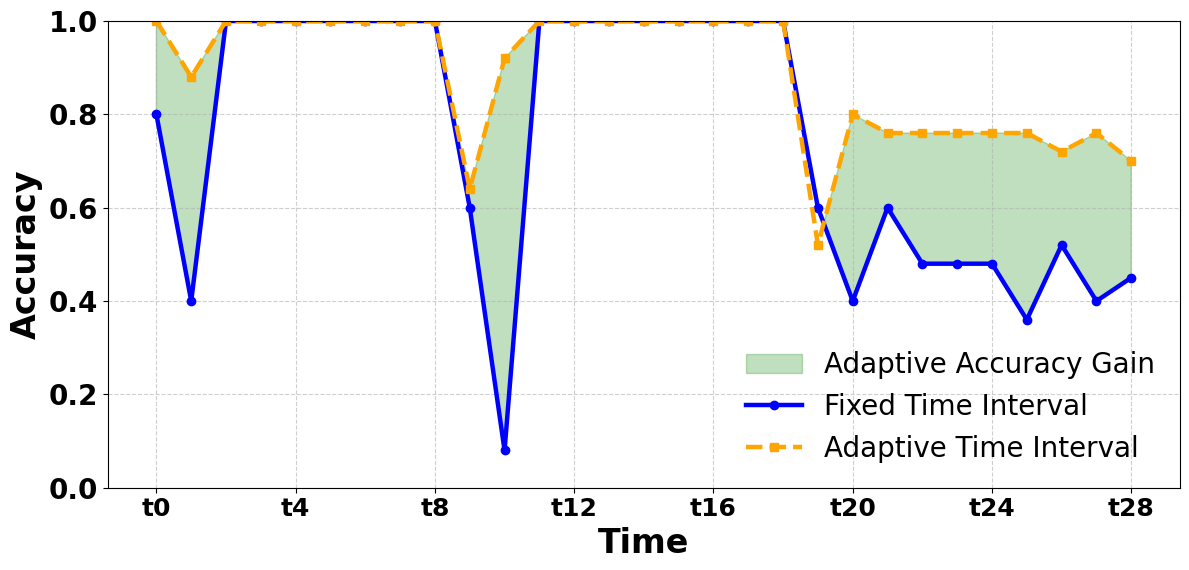

Plot saved successfully as: adaptive_vs_fixed_accuracy_v6.pdf


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load raw per-sample predictions and ground-truth ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and block grouping (every 25 samples) ===
BLOCK_SIZE = 25
df["block_group"] = (df.index // BLOCK_SIZE)

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per time step ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Create time labels (T0, T1, T2, ...) ===
summary["time_label"] = ["t" + str(i) for i in range(len(summary))]

# === Save CSV (optional) ===
summary.to_csv("accuracy_by_time_25.csv", index=False)

# === Publication-style plot ===
plt.figure(figsize=(12, 5.8))

# --- Fill green area where adaptive > fixed ---
plt.fill_between(
    summary["time_label"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Accuracy Gain"
)

# --- Fixed (solid blue) ---
plt.plot(summary["time_label"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=3.2, color="blue",
         label="Fixed Time Interval")

# --- Adaptive (dashed orange) ---
plt.plot(summary["time_label"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=3.2, color="orange",
         label="Adaptive Time Interval")

# === Axes & Labels ===
plt.xlabel("Time", fontsize=24, fontweight="bold")
plt.ylabel("Accuracy", fontsize=24, fontweight="bold")
plt.ylim(0.0, 1.0)

plt.grid(True, linestyle="--", alpha=0.6)

# --- Show fewer x-ticks (every nth label) ---
n = 4  # show every 4th label; adjust if still dense
plt.xticks(
    ticks=range(0, len(summary), n),
    labels=[summary["time_label"][i] for i in range(0, len(summary), n)],
    fontsize=18,
    fontweight="bold"
)
plt.yticks(fontsize=20, fontweight="bold")
plt.legend(fontsize=20, frameon=False, loc="lower right")
plt.tight_layout()

# === Save as PDF ===
output_path = "adaptive_vs_fixed_accuracy_v6.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")

plt.show()
print(f"Plot saved successfully as: {output_path}")


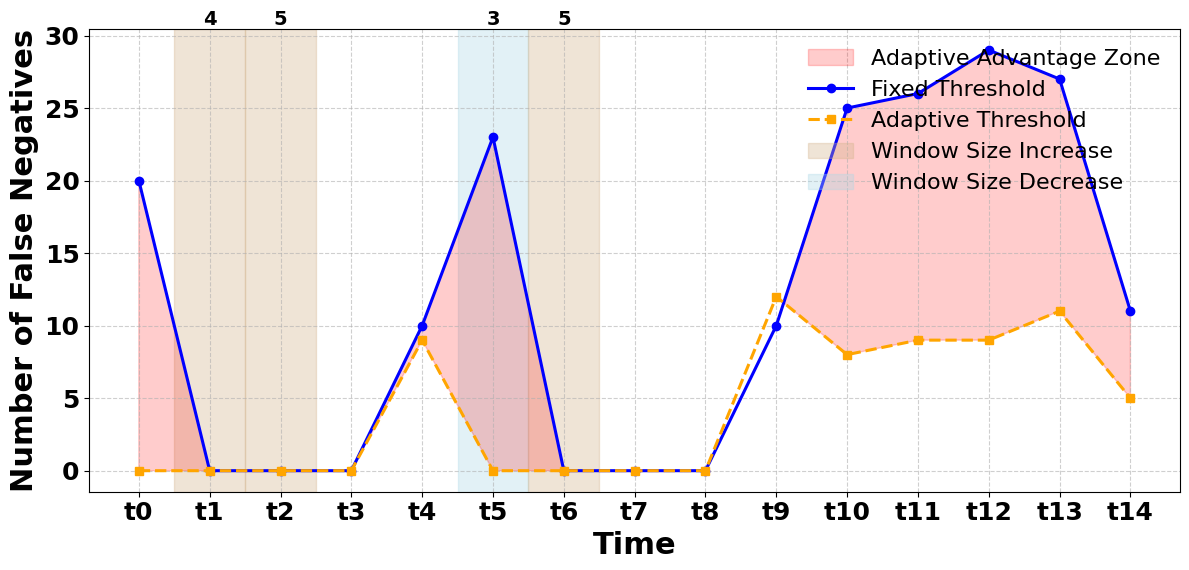

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load dataset ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and group ===
BLOCK_SIZE = 50
df["block_group"] = (df.index // BLOCK_SIZE)

# === Aggregate False Negatives and Window Size ===
summary = (
    df.groupby("block_group")[["FN", "FN1", "window_size"]]
    .agg({"FN": "sum", "FN1": "sum", "window_size": "mean"})
    .rename(columns={"FN": "false_neg_adaptive", "FN1": "false_neg_fixed"})
    .reset_index()
)

# === Create numeric time indices and labels ===
summary["t_index"] = range(len(summary))
summary["time_label"] = ["t" + str(i) for i in summary["t_index"]]

# === Detect window size changes ===
window_changes = []
for i in range(1, len(summary)):
    prev_w = summary.loc[i - 1, "window_size"]
    curr_w = summary.loc[i, "window_size"]
    if abs(curr_w - prev_w) > 0.1:  # Threshold to detect change
        window_changes.append((i, prev_w, curr_w))

# === Plot ===
plt.figure(figsize=(12, 5.8))

# --- Fill Adaptive Advantage Zone ---
plt.fill_between(
    summary["t_index"],
    summary["false_neg_adaptive"],
    summary["false_neg_fixed"],
    where=(summary["false_neg_adaptive"] < summary["false_neg_fixed"]),
    color="red",
    alpha=0.2,
    interpolate=True,
    label="Adaptive Advantage Zone"
)

# --- Fixed Threshold ---
plt.plot(summary["t_index"], summary["false_neg_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed Threshold")

# --- Adaptive Threshold ---
plt.plot(summary["t_index"], summary["false_neg_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive Threshold")

# === Highlight window size change regions ===
for change in window_changes:
    idx, prev_w, curr_w = change

    # Light brown for increase, light blue for decrease
    if curr_w > prev_w:
        color = "#d2b48c"  # light brown
        label = "Window Size Increase"
    else:
        color = "#add8e6"  # light blue
        label = "Window Size Decrease"

    # Draw shaded region
    bar = plt.axvspan(idx - 0.5, idx + 0.5, color=color, alpha=0.35, zorder=0)

    # Determine top border of the colored box
    ylim = plt.gca().get_ylim()
    top_y = ylim[1]  # the top boundary of the current axes

    # Add label *exactly* touching top of the shaded box border
    plt.text(idx, top_y, f"{int(curr_w)}",
             ha="center", va="bottom",
             fontsize=14, fontweight="bold", color="black",
             clip_on=False)

# === Labels and layout ===
plt.xlabel("Time", fontsize=22, fontweight="bold")
plt.ylabel("Number of False Negatives", fontsize=22, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(summary["t_index"], summary["time_label"], fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")

# === Legend ===
handles, labels = plt.gca().get_legend_handles_labels()
increase_patch = mpatches.Patch(color="#d2b48c", alpha=0.35, label="Window Size Increase")
decrease_patch = mpatches.Patch(color="#add8e6", alpha=0.35, label="Window Size Decrease")

plt.legend(handles + [increase_patch, decrease_patch],
           labels + ["Window Size Increase", "Window Size Decrease"],
           fontsize=16, frameon=False, loc="upper right")

plt.tight_layout()

# === Save and show ===
output_path = "false_negative_windowchange_T3_T6_topborder.pdf"
plt.savefig(output_path, format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
adapative_df.columns

Index(['window_id', 'blocks_range', 'window_size', 'drift_type', 'real_pseudo',
       'drift_ratio', 'accuracy', 'adaptive_prediction', 'ground_truth',
       'Fixed threhold prediction', 'TP1', 'FP1', 'TN1', 'FN1', 'block_group',
       'TP', 'FP', 'TN', 'FN'],
      dtype='object')

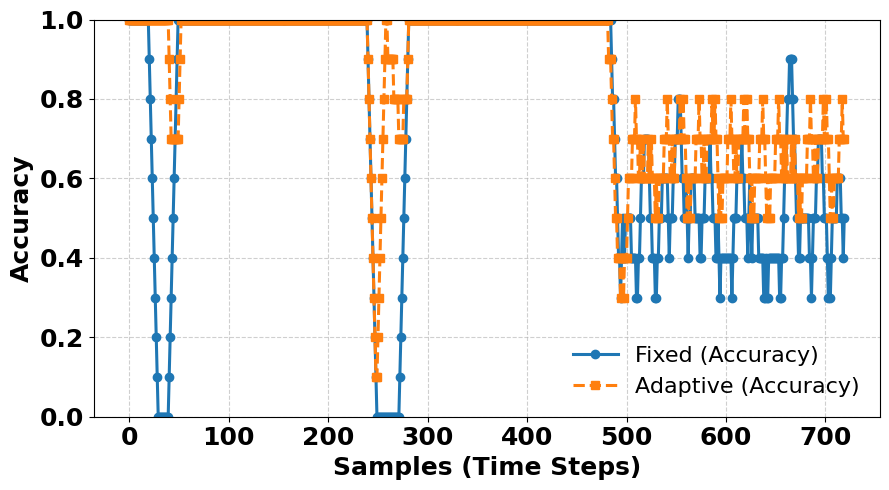

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load raw per-sample predictions and ground-truth ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Compute running accuracy (optional smoothness) ===
df["accuracy_fixed"] = df["fixed_correct"].rolling(window=10, min_periods=1).mean()
df["accuracy_adaptive"] = df["adaptive_correct"].rolling(window=10, min_periods=1).mean()

# === Plot (publication style) ===
plt.figure(figsize=(9, 5))
plt.plot(df.index, df["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, label="Fixed (Accuracy)")
plt.plot(df.index, df["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, label="Adaptive (Accuracy)")

plt.xlabel("Samples (Time Steps)", fontsize=18, fontweight="bold")
plt.ylabel("Accuracy", fontsize=18, fontweight="bold")

plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.show()


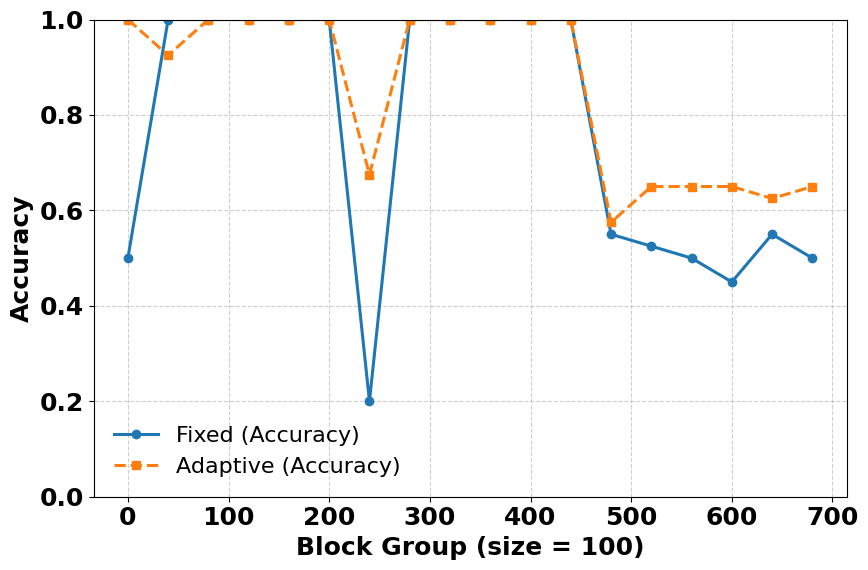

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load raw per-sample predictions and ground-truth ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and block grouping (every 100 samples) ===
BLOCK_SIZE = 40
df["block_group"] = (df.index // BLOCK_SIZE) * BLOCK_SIZE

# === Compute correctness for each method ===
# Using exact column names as provided by you
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# Save a CSV with the block-wise accuracies
out_path = "accuracy_by_block_100.csv"
summary.to_csv(out_path, index=False)

# === Publication-style plot (single axes, no explicit colors) ===
plt.figure(figsize=(8.8, 5.8))
plt.plot(summary["block_group"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, label="Fixed (Accuracy)")
plt.plot(summary["block_group"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, label="Adaptive (Accuracy)")

#plt.title("Accuracy per 100-Sample Block", fontsize=18, fontweight="bold")
plt.xlabel("Block Group (size = 100)", fontsize=18, fontweight="bold")
plt.ylabel("Accuracy", fontsize=18, fontweight="bold")

plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.legend(fontsize=16, frameon=False)
plt.tight_layout()
plt.show()


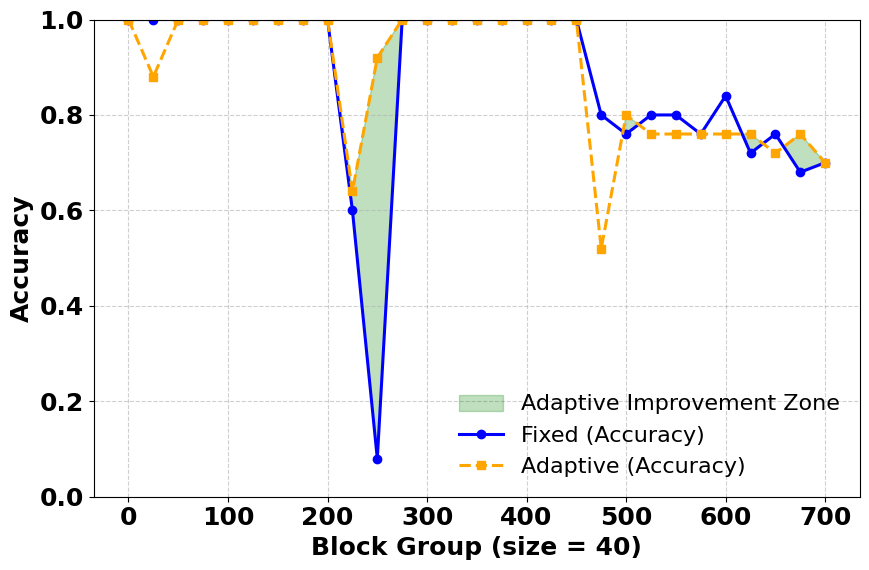

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load raw per-sample predictions and ground-truth ===
df = pd.read_csv("adaptive_drift_results.csv")

# === Define block size and block grouping (every 40 samples) ===
BLOCK_SIZE =25
df["block_group"] = (df.index // BLOCK_SIZE) * BLOCK_SIZE

# === Compute correctness for each method ===
df["fixed_correct"] = (df["Fixed threhold prediction"] == df["ground_truth"]).astype(int)
df["adaptive_correct"] = (df["adaptive_prediction"] == df["ground_truth"]).astype(int)

# === Accuracy per block ===
summary = (
    df.groupby("block_group")[["fixed_correct", "adaptive_correct"]]
    .mean()
    .rename(columns={
        "fixed_correct": "accuracy_fixed",
        "adaptive_correct": "accuracy_adaptive"
    })
    .reset_index()
)

# === Save (optional) ===
summary.to_csv("accuracy_by_block_40.csv", index=False)

# === Publication-style plot ===
plt.figure(figsize=(8.8, 5.8))

# --- Fill green area where adaptive > fixed ---
plt.fill_between(
    summary["block_group"],
    summary["accuracy_fixed"],
    summary["accuracy_adaptive"],
    where=(summary["accuracy_adaptive"] > summary["accuracy_fixed"]),
    color="green",
    alpha=0.25,
    interpolate=True,
    label="Adaptive Improvement Zone"
)

# --- Fixed (solid blue) ---
plt.plot(summary["block_group"], summary["accuracy_fixed"],
         marker="o", linestyle="-", linewidth=2.2, color="blue",
         label="Fixed (Accuracy)")

# --- Adaptive (dashed orange) ---
plt.plot(summary["block_group"], summary["accuracy_adaptive"],
         marker="s", linestyle="--", linewidth=2.2, color="orange",
         label="Adaptive (Accuracy)")

# === Axes & Labels ===
plt.xlabel("Block Group (size = 25)", fontsize=18, fontweight="bold")
plt.ylabel("Accuracy", fontsize=18, fontweight="bold")
plt.ylim(0.0, 1.0)

plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")

# === Legend & Layout ===
plt.legend(fontsize=16, frameon=False, loc="lower right")
plt.tight_layout()
plt.show()


In [ ]:
adapative_df

,window_id,blocks_range,window_size,drift_type,real_pseudo,drift_ratio,accuracy,adaptive_prediction,ground_truth,Fixed threhold prediction,TP,FP,TN,FN,block_group,TP1,FP1,TN1,FN1
0,1,0-4,5,PSEUDO_DRIFT,0/5,0.0,0.608,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
1,2,5-9,5,PSEUDO_DRIFT,0/5,0.0,0.680,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
2,3,10-14,5,PSEUDO_DRIFT,0/5,0.0,0.592,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
3,4,15-19,5,PSEUDO_DRIFT,0/5,0.0,0.620,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
4,5,20-24,5,PSEUDO_DRIFT,0/5,0.0,0.632,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,716,3477-3481,5,PSEUDO_DRIFT,2/3,0.4,0.280,PSEUDO_DRIFT,REAL_DRIFT,REAL_DRIFT,0,0,0,1,705,1,0,0,0
716,717,3482-3486,5,REAL_DRIFT,5/0,1.0,0.288,REAL_DRIFT,REAL_DRIFT,REAL_DRIFT,1,0,0,0,705,1,0,0,0
717,718,3487-3491,5,PSEUDO_DRIFT,1/4,0.2,0.648,PSEUDO_DRIFT,PSEUDO_DRIFT,PSEUDO_DRIFT,0,0,1,0,705,0,0,1,0
718,719,3492-3496,5,PSEUDO_DRIFT,1/4,0.2,0.352,PSEUDO_DRIFT,REAL_DRIFT,PSEUDO_DRIFT,0,0,0,1,705,0,0,0,1


/tmp/ipython-input-2042590678.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


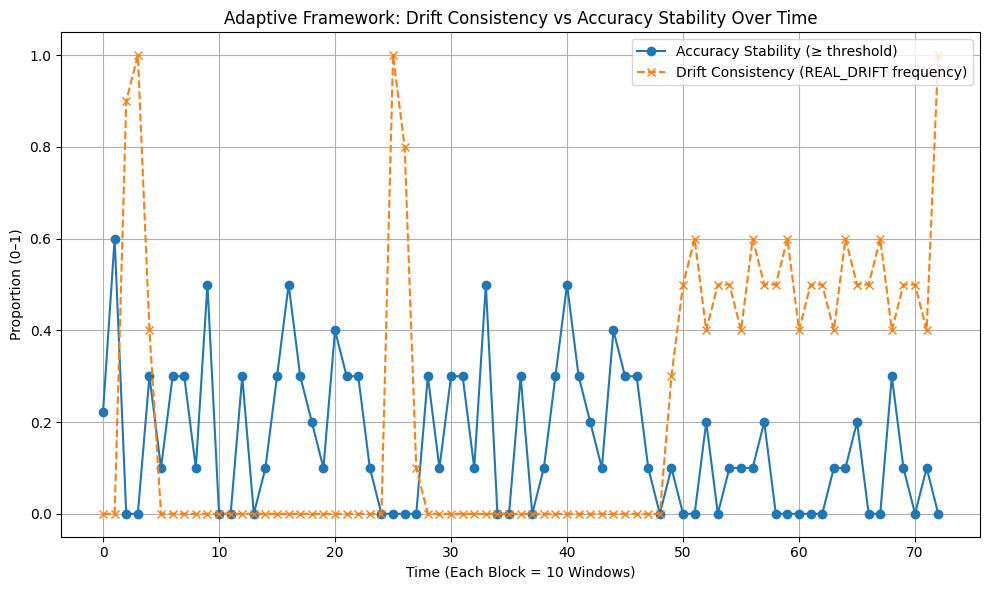

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your adaptive drift results
df = pd.read_csv("adaptive_drift_results.csv")

# Clean and prepare data
df["window_id"] = pd.to_numeric(df["window_id"], errors="coerce")
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")

# Define block grouping (10 windows = 1 time segment)
block_size = 10
df["time_block"] = (df["window_id"] // block_size).astype(int)

# === Define thresholds ===
accuracy_threshold = 0.7  # You can adjust this based on your system

# Compute drift consistency & accuracy stability
summary = (
    df.groupby("time_block")
    .apply(lambda g: pd.Series({
        "Drift_Consistency_Score": (g["drift_type"] == "REAL_DRIFT").mean(),
        "Accuracy_Stability_Score": (g["accuracy"] >= accuracy_threshold).mean()
    }))
    .reset_index()
)

# Save summary
summary.to_csv("adaptive_block_scores.csv", index=False)

# === Visualization ===
plt.figure(figsize=(10,6))
plt.plot(summary["time_block"], summary["Accuracy_Stability_Score"], 'o-', label="Accuracy Stability (≥ threshold)")
plt.plot(summary["time_block"], summary["Drift_Consistency_Score"], 'x--', label="Drift Consistency (REAL_DRIFT frequency)")

plt.xlabel("Time (Each Block = 10 Windows)")
plt.ylabel("Proportion (0–1)")
plt.title("Adaptive Framework: Drift Consistency vs Accuracy Stability Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Interval Statistics:
   time_interval  adaptive_false_negative  fixed_false_negative  \
0              0                        0                     0   
1              1                        0                     0   
2              2                        0                    10   
3              3                        0                    10   
4              4                        0                     0   
5              5                        0                     0   
6              6                        0                     0   
7              7                        0                     0   
8              8                        0                     0   
9              9                        0                     0   

   adaptive_accuracy  fixed_accuracy  accuracy  window_id  
0                1.0             1.0    0.6872         10  
1                1.0             1.0    0.7084         10  
2                1.0             0.0    0.1868         10  
3

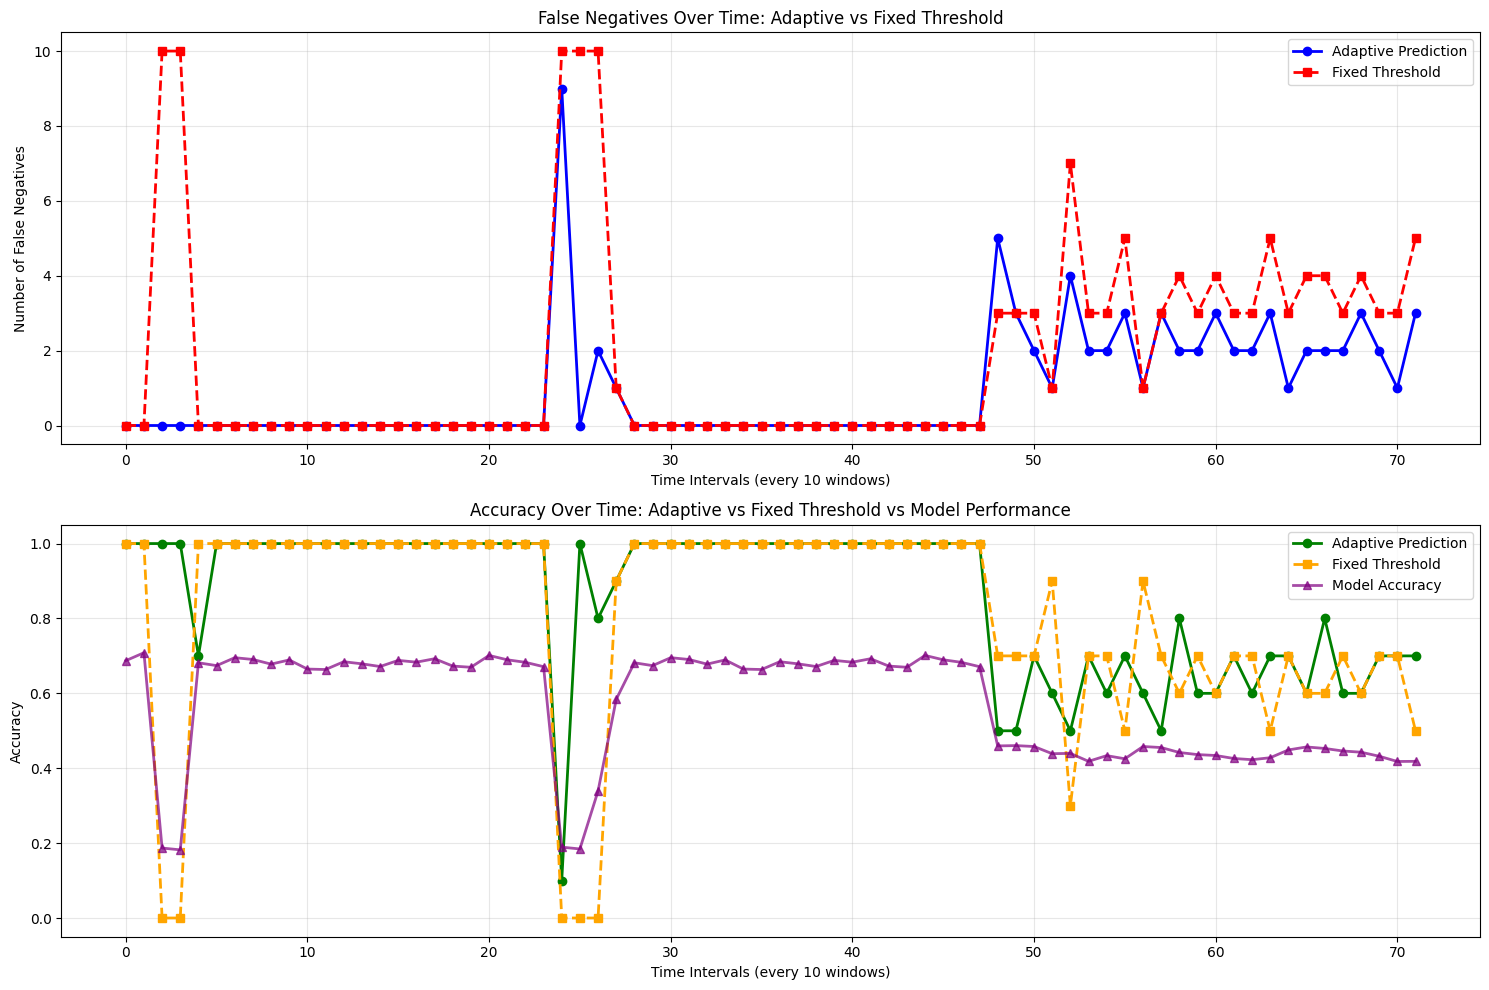


Overall Performance Summary:
Total False Negatives - Adaptive: 68
Total False Negatives - Fixed: 134
Overall Accuracy - Adaptive: 0.8583
Overall Accuracy - Fixed: 0.8139
Improvement in False Negatives: 66
Improvement in Accuracy: 0.0444


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('adaptive_drift_results.csv')

# Data cleaning - fix column name
df.columns = df.columns.str.strip()
df.rename(columns={'Fixed threhold prediction': 'Fixed_threshold_prediction'}, inplace=True)

# Create time intervals (every 10 window IDs)
df['time_interval'] = (df['window_id'] - 1) // 10

# Calculate false negatives
# False Negative: Ground Truth is REAL_DRIFT but prediction is PSEUDO_DRIFT
df['adaptive_false_negative'] = ((df['ground_truth'] == 'REAL_DRIFT') &
                                (df['adaptive_prediction'] == 'PSEUDO_DRIFT')).astype(int)

df['fixed_false_negative'] = ((df['ground_truth'] == 'REAL_DRIFT') &
                             (df['Fixed_threshold_prediction'] == 'PSEUDO_DRIFT')).astype(int)

# Calculate accuracy
df['adaptive_correct'] = (df['ground_truth'] == df['adaptive_prediction']).astype(int)
df['fixed_correct'] = (df['ground_truth'] == df['Fixed_threshold_prediction']).astype(int)

# Group by time intervals
interval_stats = df.groupby('time_interval').agg({
    'adaptive_false_negative': 'sum',
    'fixed_false_negative': 'sum',
    'adaptive_correct': 'mean',
    'fixed_correct': 'mean',
    'accuracy': 'mean',
    'window_id': 'count'  # to verify we have data in each interval
}).reset_index()

# Rename for clarity
interval_stats = interval_stats.rename(columns={
    'adaptive_correct': 'adaptive_accuracy',
    'fixed_correct': 'fixed_accuracy'
})

print("Interval Statistics:")
print(interval_stats.head(10))

# Create the plots
plt.figure(figsize=(15, 10))

# Plot 1: False Negatives over Time
plt.subplot(2, 1, 1)
plt.plot(interval_stats['time_interval'], interval_stats['adaptive_false_negative'],
         marker='o', linewidth=2, label='Adaptive Prediction', color='blue')
plt.plot(interval_stats['time_interval'], interval_stats['fixed_false_negative'],
         marker='s', linewidth=2, label='Fixed Threshold', color='red', linestyle='--')
plt.xlabel('Time Intervals (every 10 windows)')
plt.ylabel('Number of False Negatives')
plt.title('False Negatives Over Time: Adaptive vs Fixed Threshold')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy over Time
plt.subplot(2, 1, 2)
plt.plot(interval_stats['time_interval'], interval_stats['adaptive_accuracy'],
         marker='o', linewidth=2, label='Adaptive Prediction', color='green')
plt.plot(interval_stats['time_interval'], interval_stats['fixed_accuracy'],
         marker='s', linewidth=2, label='Fixed Threshold', color='orange', linestyle='--')
plt.plot(interval_stats['time_interval'], interval_stats['accuracy'],
         marker='^', linewidth=2, label='Model Accuracy', color='purple', alpha=0.7)
plt.xlabel('Time Intervals (every 10 windows)')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time: Adaptive vs Fixed Threshold vs Model Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Overall performance comparison
total_adaptive_fn = df['adaptive_false_negative'].sum()
total_fixed_fn = df['fixed_false_negative'].sum()
overall_adaptive_acc = df['adaptive_correct'].mean()
overall_fixed_acc = df['fixed_correct'].mean()

print(f"\nOverall Performance Summary:")
print(f"Total False Negatives - Adaptive: {total_adaptive_fn}")
print(f"Total False Negatives - Fixed: {total_fixed_fn}")
print(f"Overall Accuracy - Adaptive: {overall_adaptive_acc:.4f}")
print(f"Overall Accuracy - Fixed: {overall_fixed_acc:.4f}")
print(f"Improvement in False Negatives: {total_fixed_fn - total_adaptive_fn}")
print(f"Improvement in Accuracy: {overall_adaptive_acc - overall_fixed_acc:.4f}")

Window Size Analysis:
    time_interval  window_size_mean  window_size_std  adaptive_accuracy  \
0               0               5.0         0.000000                1.0   
1               1               5.0         0.000000                1.0   
2               2               5.0         0.000000                1.0   
3               3               4.0         0.000000                1.0   
4               4               3.0         0.000000                0.7   
5               5               3.7         0.483046                1.0   
6               6               4.7         0.483046                1.0   
7               7               5.0         0.000000                1.0   
8               8               5.0         0.000000                1.0   
9               9               5.0         0.000000                1.0   
10             10               5.0         0.000000                1.0   
11             11               5.0         0.000000                1.0   
12 

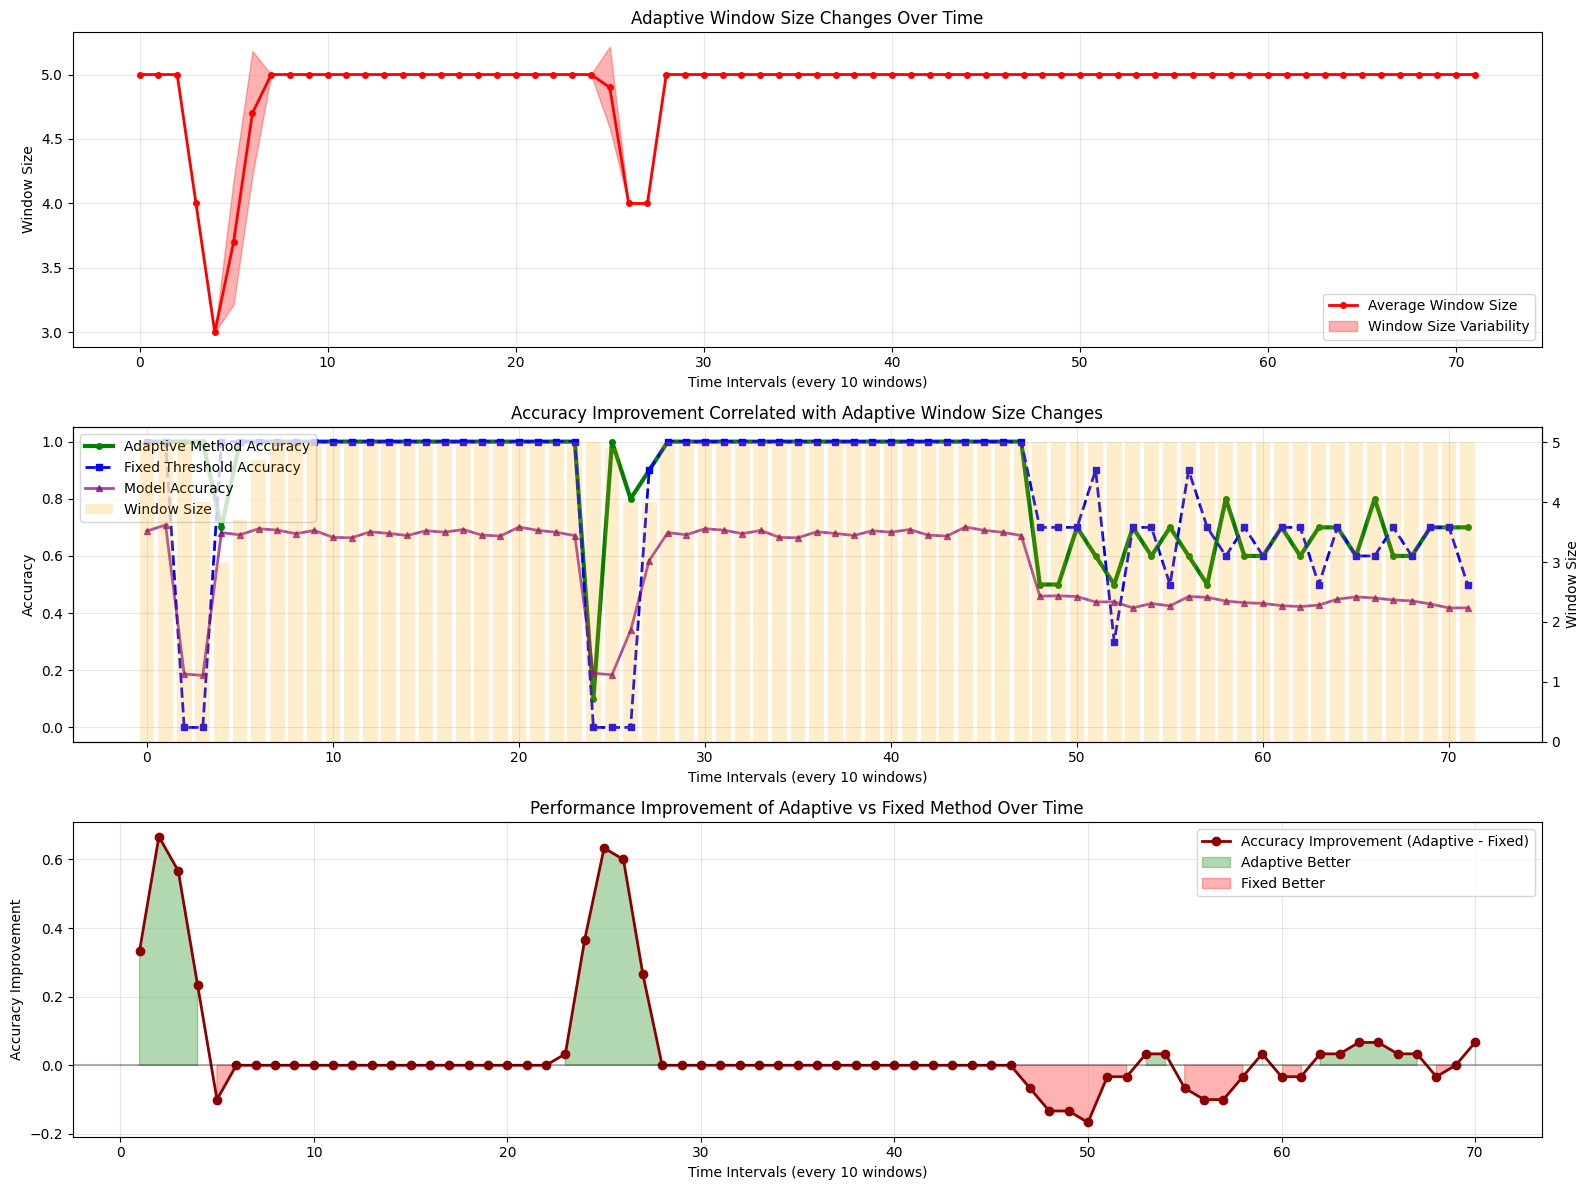


Statistical Analysis:
Correlation between Window Size and Adaptive Accuracy: -0.0102
Correlation between Window Size and Fixed Accuracy: 0.1391

Significant window size changes detected at intervals: [3, 4, 5, 6, 26, 28]
Interval 3: Accuracy changed from 1.000 to 1.000 (Δ = +0.000) after window size adjustment
Interval 4: Accuracy changed from 1.000 to 0.700 (Δ = -0.300) after window size adjustment
Interval 5: Accuracy changed from 0.700 to 1.000 (Δ = +0.300) after window size adjustment

Overall Performance Summary:
Average Adaptive Method Accuracy: 0.8583
Average Fixed Method Accuracy: 0.8139
Overall Improvement: 0.0444 (4.44%)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load the data
df = pd.read_csv('adaptive_drift_results.csv')

# Data cleaning
df.columns = df.columns.str.strip()
df.rename(columns={'Fixed threhold prediction': 'Fixed_threshold_prediction'}, inplace=True)

# Create time intervals (every 10 window IDs for smoother visualization)
df['time_interval'] = (df['window_id'] - 1) // 10

# Calculate performance metrics
df['adaptive_correct'] = (df['ground_truth'] == df['adaptive_prediction']).astype(int)
df['fixed_correct'] = (df['ground_truth'] == df['Fixed_threshold_prediction']).astype(int)

# Group by time intervals to analyze window size changes and performance
interval_analysis = df.groupby('time_interval').agg({
    'window_size': ['mean', 'std', 'min', 'max'],  # Window size statistics
    'adaptive_correct': 'mean',                    # Adaptive method accuracy
    'fixed_correct': 'mean',                       # Fixed method accuracy
    'accuracy': 'mean',                            # Model accuracy
    'window_id': 'count'                           # Number of windows in interval
}).reset_index()

# Flatten column names
interval_analysis.columns = ['time_interval', 'window_size_mean', 'window_size_std',
                           'window_size_min', 'window_size_max', 'adaptive_accuracy',
                           'fixed_accuracy', 'model_accuracy', 'window_count']

print("Window Size Analysis:")
print(interval_analysis[['time_interval', 'window_size_mean', 'window_size_std',
                       'adaptive_accuracy', 'fixed_accuracy']].head(15))

# Create the visualization
plt.figure(figsize=(16, 12))

# Plot 1: Window Size Changes Over Time
plt.subplot(3, 1, 1)
# Plot the mean window size with shaded area for variability
plt.plot(interval_analysis['time_interval'], interval_analysis['window_size_mean'],
         marker='o', linewidth=2, label='Average Window Size', color='red', markersize=4)
plt.fill_between(interval_analysis['time_interval'],
                interval_analysis['window_size_mean'] - interval_analysis['window_size_std'],
                interval_analysis['window_size_mean'] + interval_analysis['window_size_std'],
                alpha=0.3, color='red', label='Window Size Variability')
plt.xlabel('Time Intervals (every 10 windows)')
plt.ylabel('Window Size')
plt.title('Adaptive Window Size Changes Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Accuracy Comparison with Window Size Context
plt.subplot(3, 1, 2)
# Create twin axes for window size and accuracy
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot accuracy lines
line1 = ax1.plot(interval_analysis['time_interval'], interval_analysis['adaptive_accuracy'],
                marker='o', linewidth=3, label='Adaptive Method Accuracy',
                color='green', markersize=4)
line2 = ax1.plot(interval_analysis['time_interval'], interval_analysis['fixed_accuracy'],
                marker='s', linewidth=2, label='Fixed Threshold Accuracy',
                color='blue', linestyle='--', markersize=4)
line3 = ax1.plot(interval_analysis['time_interval'], interval_analysis['model_accuracy'],
                marker='^', linewidth=2, label='Model Accuracy',
                color='purple', alpha=0.7, markersize=4)

# Plot window size as bars in background
ax2.bar(interval_analysis['time_interval'], interval_analysis['window_size_mean'],
        alpha=0.2, color='orange', label='Window Size', width=0.8)

ax1.set_xlabel('Time Intervals (every 10 windows)')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Window Size')
ax1.set_title('Accuracy Improvement Correlated with Adaptive Window Size Changes')
ax1.grid(True, alpha=0.3)

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 3: Performance Improvement Analysis
plt.subplot(3, 1, 3)

# Calculate rolling improvement (difference between adaptive and fixed)
window = 3  # Smoothing window
adaptive_rolling = interval_analysis['adaptive_accuracy'].rolling(window=window, center=True).mean()
fixed_rolling = interval_analysis['fixed_accuracy'].rolling(window=window, center=True).mean()
improvement_rolling = adaptive_rolling - fixed_rolling

plt.plot(interval_analysis['time_interval'], improvement_rolling,
         marker='o', linewidth=2, color='darkred', label='Accuracy Improvement (Adaptive - Fixed)')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.fill_between(interval_analysis['time_interval'], improvement_rolling, 0,
                where=(improvement_rolling > 0), alpha=0.3, color='green',
                label='Adaptive Better')
plt.fill_between(interval_analysis['time_interval'], improvement_rolling, 0,
                where=(improvement_rolling <= 0), alpha=0.3, color='red',
                label='Fixed Better')

plt.xlabel('Time Intervals (every 10 windows)')
plt.ylabel('Accuracy Improvement')
plt.title('Performance Improvement of Adaptive vs Fixed Method Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of correlation between window size changes and performance
correlation_adaptive = stats.pearsonr(interval_analysis['window_size_mean'],
                                   interval_analysis['adaptive_accuracy'])[0]
correlation_fixed = stats.pearsonr(interval_analysis['window_size_mean'],
                                interval_analysis['fixed_accuracy'])[0]

print(f"\nStatistical Analysis:")
print(f"Correlation between Window Size and Adaptive Accuracy: {correlation_adaptive:.4f}")
print(f"Correlation between Window Size and Fixed Accuracy: {correlation_fixed:.4f}")

# Analyze specific regions where window size changes significantly
window_changes = interval_analysis['window_size_mean'].diff().abs()
significant_changes = window_changes[window_changes > 0.5]  # Threshold for significant changes

print(f"\nSignificant window size changes detected at intervals: {list(significant_changes.index)}")

# Performance before and after significant window changes
if len(significant_changes) > 0:
    for change_interval in significant_changes.index[:3]:  # Analyze first 3 significant changes
        before = interval_analysis.loc[change_interval-1, 'adaptive_accuracy'] if change_interval > 0 else None
        after = interval_analysis.loc[change_interval, 'adaptive_accuracy']

        if before is not None:
            improvement = after - before
            print(f"Interval {change_interval}: Accuracy changed from {before:.3f} to {after:.3f} "
                  f"(Δ = {improvement:+.3f}) after window size adjustment")

# Overall performance summary
adaptive_avg_acc = interval_analysis['adaptive_accuracy'].mean()
fixed_avg_acc = interval_analysis['fixed_accuracy'].mean()
improvement = adaptive_avg_acc - fixed_avg_acc

print(f"\nOverall Performance Summary:")
print(f"Average Adaptive Method Accuracy: {adaptive_avg_acc:.4f}")
print(f"Average Fixed Method Accuracy: {fixed_avg_acc:.4f}")
print(f"Overall Improvement: {improvement:.4f} ({improvement*100:.2f}%)")

Accuracy: 0.8583333333333333
F1 Score: 0.8535297487693091
Precision: 0.853658292891807
Recall: 0.8583333333333333
Confusion Matrix:
 [[497  34]
 [ 68 121]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.88      0.94      0.91       531
  REAL_DRIFT       0.78      0.64      0.70       189

    accuracy                           0.86       720
   macro avg       0.83      0.79      0.81       720
weighted avg       0.85      0.86      0.85       720



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
# Example: assume your dataframe has columns 'actual' and 'predicted'
y_true = adapative_df["ground_truth"][:]
y_pred = adapative_df["Fixed threhold prediction"][:]
# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1  = f1_score(y_true, y_pred, average="weighted")   # use 'macro' or 'micro' if needed
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# Detailed report (per class precision, recall, f1)
report = classification_report(y_true, y_pred)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)

Accuracy: 0.9708333333333333
F1 Score: 0.9709068501706408
Precision: 0.9710227272727272
Recall: 0.9708333333333333
Confusion Matrix:
 [[519  12]
 [  9 180]]
Classification Report:
               precision    recall  f1-score   support

PSEUDO_DRIFT       0.98      0.98      0.98       531
  REAL_DRIFT       0.94      0.95      0.94       189

    accuracy                           0.97       720
   macro avg       0.96      0.96      0.96       720
weighted avg       0.97      0.97      0.97       720



In [ ]:
df_accuracies

,block_range,accuracy,Ground truth
0,0-4,0.688,PSEUDO_DRIFT
1,5-9,0.716,PSEUDO_DRIFT
2,10-14,0.680,PSEUDO_DRIFT
3,15-19,0.652,PSEUDO_DRIFT
4,20-24,0.716,PSEUDO_DRIFT
...,...,...,...
715,3575-3579,0.264,REAL_DRIFT
716,3580-3584,0.304,REAL_DRIFT
717,3585-3589,0.744,PSEUDO_DRIFT
718,3590-3594,0.324,REAL_DRIFT


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical

# --- config ---
features = ['accelerometer_x', 'accelerometer_y', 'accelerometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z', 'accelerometer_x_mean',
       'accelerometer_x_std', 'accelerometer_x_mad', 'accelerometer_x_max',
       'accelerometer_x_min', 'accelerometer_x_sma', 'accelerometer_y_mean',
       'accelerometer_y_std', 'accelerometer_y_mad', 'accelerometer_y_max',
       'accelerometer_y_min', 'accelerometer_y_sma', 'accelerometer_z_mean',
       'accelerometer_z_std', 'accelerometer_z_mad', 'accelerometer_z_max',
       'accelerometer_z_min', 'accelerometer_z_sma', 'gyroscope_x_mean',
       'gyroscope_x_std', 'gyroscope_x_mad', 'gyroscope_x_max',
       'gyroscope_x_min', 'gyroscope_x_sma', 'gyroscope_y_mean',
       'gyroscope_y_std', 'gyroscope_y_mad', 'gyroscope_y_max',
       'gyroscope_y_min', 'gyroscope_y_sma', 'gyroscope_z_mean',
       'gyroscope_z_std', 'gyroscope_z_mad', 'gyroscope_z_max',
       'gyroscope_z_min', 'gyroscope_z_sma']
target = 'activity'
num_classes = 5  # adjust to your actual number of activity classes
time_steps = len(features)

# --- evaluation over 5-block windows ---
accuracies = []
block_ids = sorted(df_tmp['block'].unique())

# process in chunks of 5 blocks at a time
for i in range(0, len(block_ids), 5):
    block_chunk = block_ids[i:i+5]
    df_chunk = df_tmp[df_tmp['block'].isin(block_chunk)]
    if df_chunk.empty:
        continue

    # prepare X and y
    X_chunk = df_chunk[features].values
    y_chunk = df_chunk[target].values

    # normalize
    X_chunk = scaler.transform(X_chunk)

    # reshape for CNN (samples, time_steps, channels)
    X_chunk = X_chunk.reshape(-1, time_steps, 1)

    # one-hot encode y
    y_chunk_cat = to_categorical(y_chunk, num_classes=num_classes)

    # evaluate model on this chunk
    loss, accuracy = model.evaluate(X_chunk, y_chunk_cat, verbose=0)
    accuracies.append({
        'block_range': f"{block_chunk[0]}-{block_chunk[-1]}",
        'accuracy': accuracy
    })
# convert to DataFrame
df_accuracies = pd.DataFrame(accuracies)
# save or inspect
df_accuracies.to_csv('blockwise_accuracies.csv', index=False)
print(df_accuracies)

   block_range  accuracy
0          0-4     0.940
1          5-9     0.916
2        10-14     0.908
3        15-19     0.860
4        20-24     0.808
5        25-29     0.804
6        30-34     0.752
7        35-39     0.764
8        40-44     0.680
9        45-49     0.620
10       50-54     0.600
11       55-59     0.628
12       60-64     0.588
13       65-69     0.516
14       70-74     0.504
15       75-79     0.500
16       80-84     0.412
17       85-89     0.388
18       90-94     0.456
19       95-99     0.300
20     100-104     0.360
21     105-109     0.236
22     110-114     0.232
23     115-119     0.244


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class AdaptiveDriftDetector:
    def __init__(self, threshold=0.6, initial_window_size=5, trend_length=5,
                 adaptation_step=1, min_window=2, max_window=15):
        self.threshold = threshold
        self.window_size = initial_window_size
        self.trend_length = trend_length
        self.adaptation_step = adaptation_step
        self.min_window = min_window
        self.max_window = max_window

        self.drift_history = []
        self.current_window_data = []
        self.results = []

        # Statistics counters
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

    def classify_drift_type(self, window_des_values, drift_detected, drift_ratio):
        """Classify the type of drift detection"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)

        if drift_detected:
            return "REAL_DRIFT", real_drift_count, total_values
        else:
            return "PSEUDO_DRIFT", real_drift_count, total_values

    def analyze_window(self, window_des_values):
        """Analyze a window and return detailed classification"""
        real_drift_count = sum(1 for des in window_des_values if des > self.threshold)
        total_values = len(window_des_values)
        drift_ratio = real_drift_count / total_values if total_values > 0 else 0

        drift_detected = drift_ratio > 0.5
        drift_type, real_count, total_count = self.classify_drift_type(
            window_des_values, drift_detected, drift_ratio
        )

        return {
            'drift_detected': drift_detected,
            'drift_type': drift_type,
            'drift_ratio': drift_ratio,
            'real_drift_count': real_count,
            'total_values': total_count,
            'pseudo_drift_count': total_count - real_count
        }

    def process_stream(self, des_stream):
        """Process the entire DES stream with detailed classification"""
        self.results = []
        self.real_drifts = 0
        self.pseudo_drifts = 0
        self.total_windows = 0

        for i, des_value in enumerate(des_stream):
            self.current_window_data.append(des_value)

            if len(self.current_window_data) == self.window_size:
                analysis = self.analyze_window(self.current_window_data)

                self.total_windows += 1
                if analysis['drift_type'] == 'REAL_DRIFT':
                    self.real_drifts += 1
                else:
                    self.pseudo_drifts += 1

                result = {
                    'window_id': self.total_windows,
                    'start_block': i - self.window_size + 1,
                    'end_block': i,
                    'window_size': self.window_size,
                    'des_values': self.current_window_data.copy(),
                    **analysis
                }
                self.results.append(result)

                self.drift_history.append(analysis['drift_detected'])
                if len(self.drift_history) > self.trend_length:
                    self.drift_history.pop(0)

                self.adapt_window_size()
                self.current_window_data = []

        return self.results

    def adapt_window_size(self):
        """Adapt window size based on drift history trend"""
        if len(self.drift_history) < self.trend_length:
            return

        if all(self.drift_history[-self.trend_length:]):
            new_size = max(self.min_window, self.window_size - self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: UNDER-sensitive → Reducing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

        elif not any(self.drift_history[-self.trend_length:]):
            new_size = min(self.max_window, self.window_size + self.adaptation_step)
            if new_size != self.window_size:
                print(f"Adaptation: OVER-sensitive → Increasing window {self.window_size}→{new_size}")
                self.window_size = new_size
                self.drift_history = []

    def get_detailed_summary(self):
        """Generate comprehensive summary of all detections"""
        if not self.results:
            return "No data processed yet."

        total_real_drift_instances = sum(r['real_drift_count'] for r in self.results)
        total_pseudo_drift_instances = sum(r['pseudo_drift_count'] for r in self.results)
        total_instances = total_real_drift_instances + total_pseudo_drift_instances

        window_sizes = [r['window_size'] for r in self.results]
        unique_window_sizes = set(window_sizes)

        summary = {
            'total_windows_analyzed': self.total_windows,
            'real_drift_windows': self.real_drifts,
            'pseudo_drift_windows': self.pseudo_drifts,
            'total_instances_analyzed': total_instances,
            'real_drift_instances': total_real_drift_instances,
            'pseudo_drift_instances': total_pseudo_drift_instances,
            'real_drift_percentage': (self.real_drifts / self.total_windows * 100) if self.total_windows > 0 else 0,
            'window_size_distribution': {size: window_sizes.count(size) for size in unique_window_sizes},
            'final_window_size': self.window_size
        }

        return summary


    def print_detailed_results(self, acc_df, max_results=720):
        """Print detailed results in a readable format including per-window accuracies"""
        print("=" * 80)
        print("ADAPTIVE DRIFT DETECTION RESULTS")
        print("=" * 80)

        print(f"\nDETAILED WINDOW ANALYSIS (showing first {max_results} results):")
        print("-" * 100)
        print(f"{'Window':<6} {'Blocks':<12} {'Size':<4} {'Type':<12} "
              f"{'Real/Pseudo':<12} {'Ratio':<8} {'Accuracy':<10}")
        print("-" * 100)

        detailed_rows = []  # store for CSV

        for i, result in enumerate(self.results[:max_results]):
            blocks_range = f"{result['start_block']}-{result['end_block']}"
            drift_type = result['drift_type']
            real_pseudo = f"{result['real_drift_count']}/{result['pseudo_drift_count']}"
            ratio = f"{result['drift_ratio']:.2f}"

            acc_value = None
            if i < len(acc_df):
                acc_value = acc_df.iloc[i]['accuracy']

            print(f"{result['window_id']:<6} {blocks_range:<12} {result['window_size']:<4} "
                  f"{drift_type:<12} {real_pseudo:<12} {ratio:<8} "
                  f"{acc_value if acc_value is not None else 'NA':<10}")

            detailed_rows.append({
                'window_id': result['window_id'],
                'blocks_range': blocks_range,
                'window_size': result['window_size'],
                'drift_type': drift_type,
                'real_pseudo': real_pseudo,
                'drift_ratio': result['drift_ratio'],
                'accuracy': acc_value if acc_value is not None else 'NA'
            })

        # Convert to DataFrame and save to CSV
        df_detailed = pd.DataFrame(detailed_rows)
        df_detailed.to_csv('adaptive_drift_results.csv', index=False)
        print("\n✅ Detailed results saved as 'adaptive_drift_results.csv'")

        summary = self.get_detailed_summary()
        print("\n" + "=" * 80)
        print("SUMMARY STATISTICS")
        print("=" * 80)
        print(f"Total windows analyzed: {summary['total_windows_analyzed']}")
        print(f"Real drift windows: {summary['real_drift_windows']} "
              f"({summary['real_drift_percentage']:.1f}%)")
        print(f"Pseudo drift windows: {summary['pseudo_drift_windows']}")
        print(f"Total instances analyzed: {summary['total_instances_analyzed']}")
        print(f"Real drift instances: {summary['real_drift_instances']}")
        print(f"Pseudo drift instances: {summary['pseudo_drift_instances']}")
        print(f"Final window size: {summary['final_window_size']}")
        print(f"Window size distribution: {summary['window_size_distribution']}")


# =========================
# Usage Example
# =========================
def main():
    des_df = pd.read_csv('/content/df_des_gradual.csv')
    acc_df = pd.read_csv('/content/Ground.csv')

    scaler = MinMaxScaler()
    des_df['DES_scaled'] = scaler.fit_transform(des_df[['DES']])
    des_values = des_df['DES_scaled'].tolist()

    detector = AdaptiveDriftDetector(
        threshold=0.4,
        initial_window_size=5,
        trend_length=10,
        adaptation_step=1,
        min_window=2,
        max_window=5
    )
    detector.process_stream(des_values)
    detector.print_detailed_results(acc_df)
    detailed_summary = detector.get_detailed_summary()
    print("\nRaw summary data:", detailed_summary)
if __name__ == "__main__":
    main()


In [43]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import mahalanobis

df = pd.read_csv("adaptive_drift_results.csv")
WINDOW_INTERVAL = 5  # minutes
df["time_min"] = df["window_id"] * WINDOW_INTERVAL

# === Confusion counts ===
TP_adapt, FP_adapt, FN_adapt, TN_adapt = df[["TP","FP","FN","TN"]].sum()
TP_fixed, FP_fixed, FN_fixed, TN_fixed = df[["TP1","FP1","FN1","TN1"]].sum()

# === Detection Delay calculation ===
def detection_delay(df, pred_col):
    delays = []
    real_idx = df.index[df["ground_truth"] == "REAL_DRIFT"]
    for onset in real_idx:
        after = df.loc[onset:, pred_col].eq("REAL_DRIFT")
        if after.any():
            alarm = after.idxmax()
            delay = (alarm - onset) * WINDOW_INTERVAL
            delays.append(delay)
    return np.mean(delays) if delays else np.nan, np.std(delays) if delays else np.nan, delays

dd_adapt_mean, dd_adapt_std, delays_adapt = detection_delay(df, "adaptive_prediction")
dd_fixed_mean, dd_fixed_std, delays_fixed = detection_delay(df, "Fixed threhold prediction")

# === Metrics ===
EDG = 100 * (dd_fixed_mean - dd_adapt_mean) / dd_fixed_mean if dd_fixed_mean > 0 else np.nan
TFD_adapt = delays_adapt[0] if delays_adapt else np.nan
TFD_fixed = delays_fixed[0] if delays_fixed else np.nan
FN_reduction = 100 * (FN_fixed - FN_adapt) / FN_fixed if FN_fixed > 0 else 0
MD_adapt = FN_adapt / (FN_adapt + TP_adapt) if (FN_adapt + TP_adapt) > 0 else np.nan
MD_fixed = FN_fixed / (FN_fixed + TP_fixed) if (FN_fixed + TP_fixed) > 0 else np.nan

# Mahalanobis Distance
try:
    perf = pd.DataFrame([[TP_fixed, FP_fixed, FN_fixed, TN_fixed],
                         [TP_adapt, FP_adapt, FN_adapt, TN_adapt]],
                        columns=["TP","FP","FN","TN"])
    S = np.cov(perf.T)
    inv_S = np.linalg.pinv(S)
    MaD = mahalanobis(perf.iloc[1], perf.iloc[0], inv_S)
except np.linalg.LinAlgError:
    MaD = np.nan

# === Summary ===
summary = pd.DataFrame({
    "Metric": [
        "Detection Delay (min)", "EDG (%)", "TFD (min)",
        "FN", "FP", "Miss Detection Rate (MD)",
        "FN Reduction (%)"
    ],
    "Fixed-Interval": [
        f"{dd_fixed_mean:.2f} ± {dd_fixed_std:.2f}",
        "-", f"{TFD_fixed if TFD_fixed else np.nan}",
        FN_fixed, FP_fixed, f"{MD_fixed:.3f}", "-"
    ],
    "Adaptive-PDD": [
        f"{dd_adapt_mean:.2f} ± {dd_adapt_std:.2f}",
        f"{EDG:.2f}", f"{TFD_adapt if TFD_adapt else np.nan}",
        FN_adapt, FP_adapt, f"{MD_adapt:.3f}",
        f"{FN_reduction:.2f}"
    ]
})
print("\n=== Drift Detection Comparative Summary ===\n")
print(summary.to_string(index=False))
print(f"\nMahalanobis Distance (Adaptive vs Fixed): {MaD:.3f}")



=== Drift Detection Comparative Summary ===

                  Metric  Fixed-Interval Adaptive-PDD
   Detection Delay (min) 428.46 ± 723.56 5.39 ± 15.36
                 EDG (%)               -        98.74
               TFD (min)            2310          nan
                      FN             181           63
                      FP               0           17
Miss Detection Rate (MD)           0.883        0.307
        FN Reduction (%)               -        65.19

Mahalanobis Distance (Adaptive vs Fixed): 1.414
